# Examples

In this colab, we will introduce how to create random forests, interact with specific trees within it, and visualize information from the forest as a whole. You will then apply this technique to the same challenges you've covered in the morning, and assess if the random forest models are more performant than the individual trees we created.

Let's look at the absenteism data again



In [ ]:
import numpy as np
import pandas as pd

#load the data
data = pd.read_excel('/content/Absenteeism_at_work.xlsx', index_col='ID')

#displaying the dataset
data.describe()


Reason for absence  ...  Absenteeism time in hours
count          740.000000  ...                 740.000000
mean            19.216216  ...                   6.924324
std              8.433406  ...                  13.330998
min              0.000000  ...                   0.000000
25%             13.000000  ...                   2.000000
50%             23.000000  ...                   3.000000
75%             26.000000  ...                   8.000000
max             28.000000  ...                 120.000000

[8 rows x 20 columns]

The columns should be fairly familiar at this stage, so let's start creating our random forest. In this scenario, we will not select specific features. Rather, our tree will randomly select some and assign them to random trees

In [ ]:
from sklearn.model_selection import train_test_split

# Split the independent and dependent variables
# We want to predict if someone is a social drinker, so let's use that column as our Y 
y = data['Hit target'].values


test_features = data.columns.to_list()
test_features.remove('Hit target')

# We should be able to use nearly all the other features, but for the sake of simplifying our visualization later, we only pick a few.
X = data[test_features].values

# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# Import the model
from sklearn.ensemble import RandomForestRegressor

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
forest = RandomForestRegressor(n_estimators = 100, random_state=42, min_samples_split = 20, max_depth=5)
forest = forest.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = forest.predict(X_test)


comparison_frame = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

comparison_frame.describe()


Actual   Predicted
count  222.000000  222.000000
mean    94.378378   94.329951
std      3.767098    3.379547
min     81.000000   81.351916
25%     92.000000   92.644231
50%     95.000000   95.306072
75%     97.000000   96.765204
max    100.000000   99.000000

Let's assess how well our random forest is doing.

In [ ]:
from sklearn import metrics

# And now we assess the errors
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 0.7018132999810903
Mean Squared Error: 0.9064345513240264
Root Mean Squared Error: 0.9520685644028094


We've doubled the performance of our model as far as RMSE is concerned! Random forests will typically beat the performance of individual trees. 

Talking about individual trees, our forest used 500 trees. Let's see what tree #50 looks like: 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


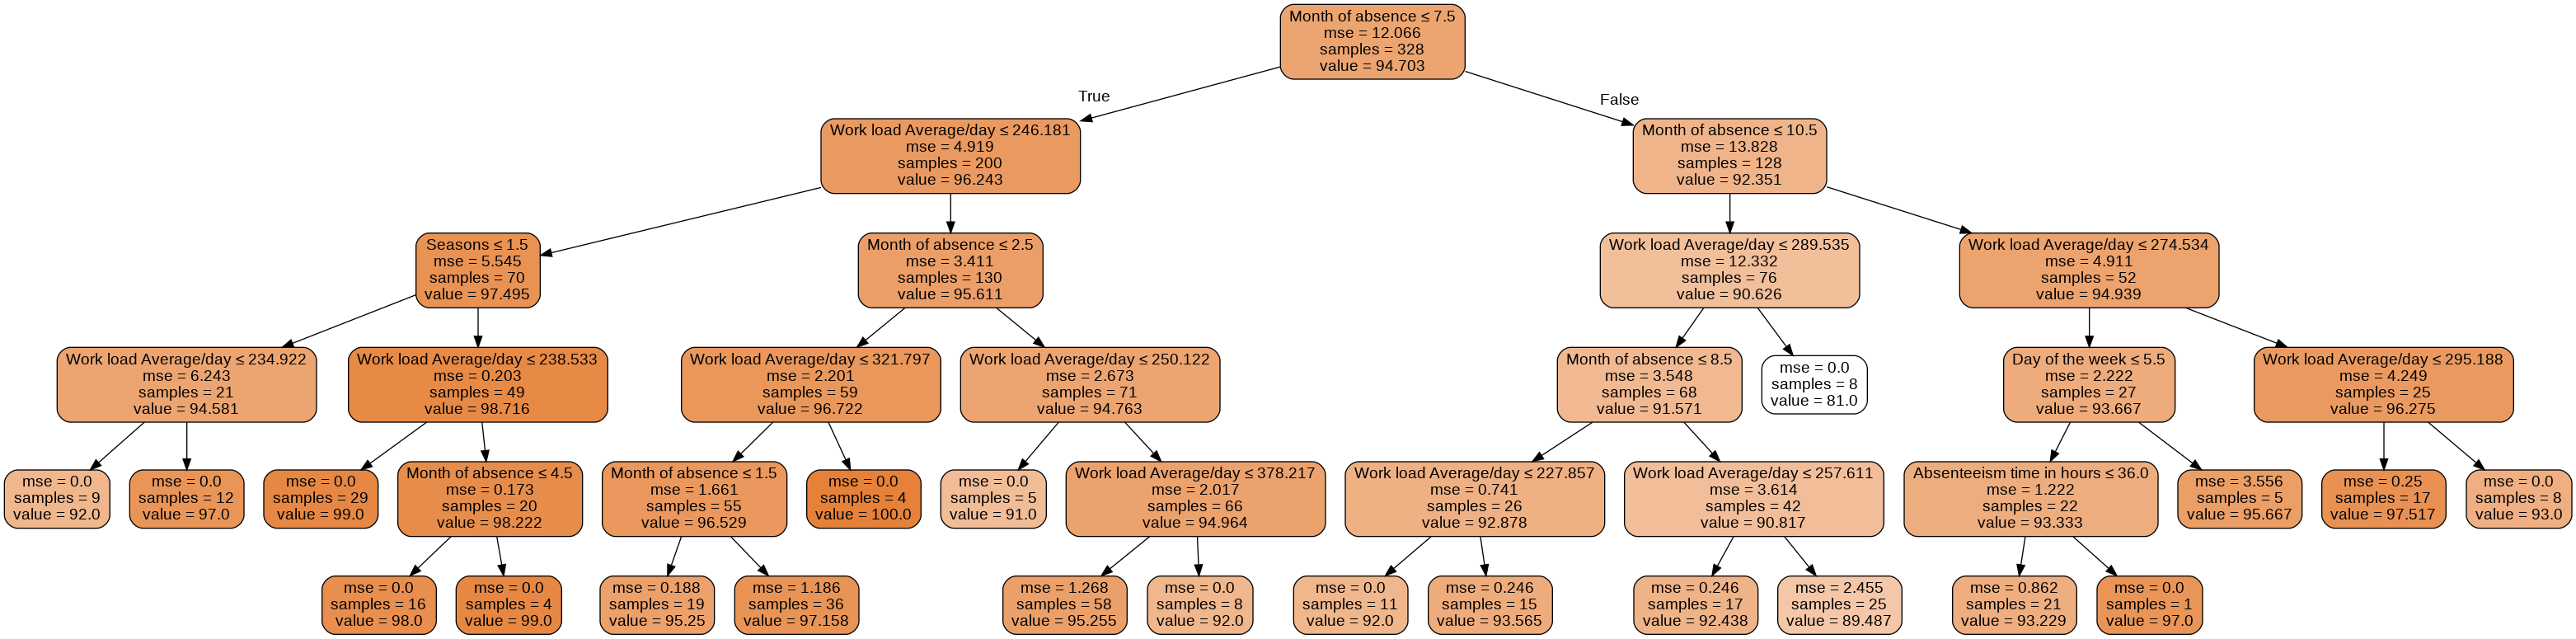

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
# pick a specific tree from the forest
tree = forest.estimators_[50]

export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = test_features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('absenteism_forest.png')
Image(graph.create_png())


Notice that some of the features exhibited here were never included in our past model. You should often see these features if you display other trees, but the trees will have slight differences of features or tests in multiple nodes.

To close the topic on features, let's learn how to visualize feature importance: After creating a random forest, the model has a very strong sense of which features matter most. 


In [ ]:
# Get numerical feature importances
importances = list(tree.feature_importances_)

# We now use some Python magic to connect each feature with its importance
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(test_features, importances)]

print(feature_importances) #this already has all the information we need, but it can be tricky to see when there are too many features.
print()

# Nice to have: We can sort the values in descending order, since we care about the most important features first.
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


[('Reason for absence', 0.0), ('Month of absence', 0.54), ('Day of the week', 0.0), ('Seasons', 0.06), ('Transportation expense', 0.0), ('Distance from Residence to Work', 0.0), ('Service time', 0.0), ('Age', 0.0), ('Work load Average/day', 0.39), ('Disciplinary failure', 0.0), ('Education', 0.0), ('Son', 0.0), ('Social drinker', 0.0), ('Social smoker', 0.0), ('Pet', 0.0), ('Weight', 0.0), ('Height', 0.0), ('Body mass index', 0.0), ('Absenteeism time in hours', 0.0)]

Variable: Month of absence     Importance: 0.54
Variable: Work load Average/day Importance: 0.39
Variable: Seasons              Importance: 0.06
Variable: Reason for absence   Importance: 0.0
Variable: Day of the week      Importance: 0.0
Variable: Transportation expense Importance: 0.0
Variable: Distance from Residence to Work Importance: 0.0
Variable: Service time         Importance: 0.0
Variable: Age                  Importance: 0.0
Variable: Disciplinary failure Importance: 0.0
Variable: Education            Importanc

In [ ]:
col=data[['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons',
       'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day','Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',
       'Absenteeism time in hours']]
importance=pd.DataFrame(tree.feature_importances_,col.columns,columns=['Importance'])
importance

Importance
Reason for absence                 0.000000
Month of absence                   0.539227
Day of the week                    0.004762
Seasons                            0.063547
Transportation expense             0.000000
Distance from Residence to Work    0.000000
Service time                       0.000000
Age                                0.000000
Work load Average/day              0.390111
Disciplinary failure               0.000000
Education                          0.000000
Son                                0.000000
Social drinker                     0.000000
Social smoker                      0.000000
Pet                                0.000000
Weight                             0.000000
Height                             0.000000
Body mass index                    0.000000
Absenteeism time in hours          0.002352

We can also represent this visually: 

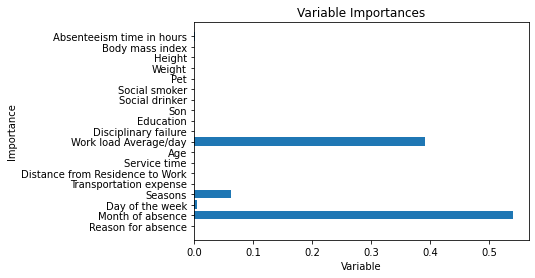

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

# list of x locations for plotting
y_values = list(range(len(importances)))
# Make a bar chart
plt.barh(y_values, importances, orientation = 'horizontal')
# Tick labels for x axis
plt.yticks(x_values, test_features, rotation='horizontal')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


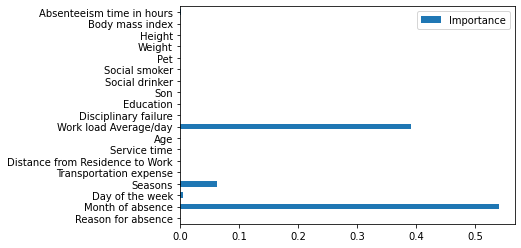

In [ ]:
importance.plot(kind='barh')

The implications here are great: If we are trying to predict the hit target, we only need 3 variables: Month of absence, Seasons, Work load averages. The first challenge bellow will get you doing just that!

# Challenge 1

Create a new random forest making the same prediction as above, but only use the 3 variables we've identified above: Month of absence, Seasons, and Work load averages.

compare the performance of your new forest with the one above, what do you notice?

In [ ]:
feat=['Month of absence','Seasons','Work load Average/day']
cola=data[feat]
x1=data[feat].values
y1=data['Hit target'].values
xtrain,xtest,ytrain,ytest=train_test_split(x1,y1,test_size=0.2,random_state=42)

In [ ]:
rr=RandomForestRegressor(n_estimators=600,max_depth=5)
rr.fit(xtrain,ytrain)
pred=rr.predict(xtest)
print('RMSE:',np.sqrt(metrics.mean_squared_error(ytest,pred)))

RMSE: 0.8930604491664818


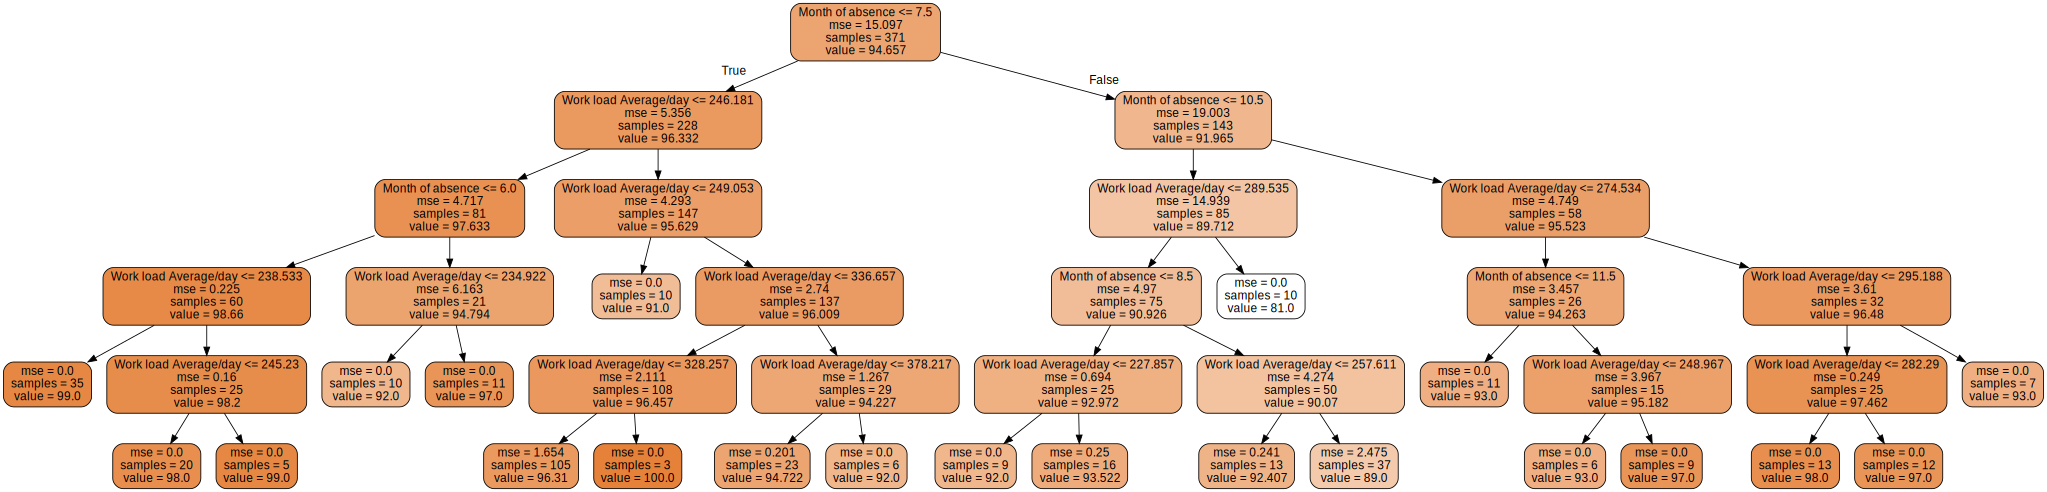

In [ ]:
rtree=rr.estimators_[60]
import graphviz
g=export_graphviz(rtree, feature_names=feat, filled=True,rounded= True)
graph=graphviz.Source(g,format='png')
graph

In [ ]:
importa=pd.DataFrame(rr.feature_importances_,cola.columns,columns=['Importance'])
importa

Importance
Month of absence         0.576933
Seasons                  0.018248
Work load Average/day    0.404820

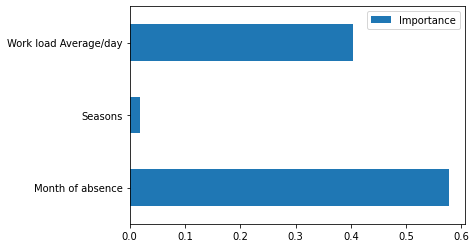

In [ ]:
importa.plot(kind='barh')

# Challenge 2

Revisit challenge 2 from the classification collab:


*   Create a random forest model instead of your individual tree
*   Visualize the relevance of the various features that contribute to the model
*   Compare the performance of your new model to your earlier one.

Note that you can use a random forest as a classifier simply by doing the following:



```
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
```



**As a reminder, here are the instructions for the previous challenge:**

For this challenge we will use a different data set on banking information. This set contains data on various individuals, their banking status, and how much marketing content they have received from the bank. You are to create a model that predicts whether or not they will subscribe to a term deposit, indicated by the variable **y** in the dataset.

For more information about the various columns, take a look at this [site](https://data.world/data-society/bank-marketing-data)

How accurate is the model you've created? What parameters have you used to tweak it? 

Once you are confident with the model you've created, bring in this separate dataset:


```
further_test = pd.read_csv('https://query.data.world/s/qy4uqnoc56ydidfkkneozx3rmmmq7o', delimiter = ';')
```

Test your model's accuracy against this new set. What can you conclude about the fit of your model?




In [ ]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/nr56ywwu5g7m5lystbjm25ouxj2l6e', delimiter = ';')
df.columns
# Your code goes here

# Challenge 3

Revisit challenge 2 from the regressor collab:


*   Create a random forest model instead of your individual tree
*   Visualize the relevance of the various features that contribute to the model
*   Compare the performance of your new model to your earlier one.

**As a reminder, here are the instructions for the previous challenge:**
Consider the following [dataset](https://drive.google.com/open?id=1ZY1syF1NGZFoJjtVrpDFyad-xSR1T_y5rjG5OulPa_I) which contains information about airbnb rentals in NYC. This includes the room time, neighborhood, price, etc. 
You can find more context on it [here](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/downloads/new-york-city-airbnb-open-data.zip/3)

Your task is to create a model which predicts the price charged by an air bnb given information such as reviews, neighborhood, room type, etc.

This is a large dataset, so make sure to contain the growth of your tree, use appropriate min_samples_split and max_depth values, iterating until you find a balance between training time and the quality of the model 

Answer the following questions with a peer:

*   Any crucial insight from your initial EDA?
*   How accurate is your model? Any concerns of overfitting or underfitting?
*   What features are most influential in determining pricing? does that make intuitive sense to you?




In [ ]:
# Your code goes here!